# Regression on latent space of CAE
* Train CAE on reconstruction.
* Fix encoder weights.
* Generate regression truths as sum of pixel values.
* Train regressor on this data.

$\rightarrow$ This problem is similar to recovering the energy content of a shower

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf

In [2]:
nepochs     = 50
batch_size  = 32
latent_dims = 16

### 1. Generate data

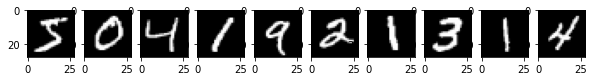

In [7]:
nrows, ncols = 28, 28
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data() # load
X_train, X_test = tf.reshape(X_train, (-1,nrows,ncols,1)), tf.reshape(X_test, (-1,nrows,ncols,1)) # reshape
X_train, X_test = tf.cast(X_train, 'float32') / 255., tf.cast(X_test, 'float32') / 255.  # MinMax scale
Y_train, Y_test = np.sum(X_train, axis=(1,2,3)), np.sum(X_test, axis=(1,2,3))

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X_train[i], (nrows, ncols)), vmin=0, vmax=1)

### 2. Create model

In [4]:
def build_encoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=n, activation='linear', use_bias=False),
    ])

def build_decoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

def build_regressor(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=64, activation='relu', use_bias=False),
        keras.layers.Dense(units=32, activation='relu', use_bias=False),
        keras.layers.Dense(units=16, activation='relu', use_bias=False),
        keras.layers.Dense(units=1, activation='linear', use_bias=False),
    ])

### 3. Train model
* Train latent space on reco, fix encoder, train regressor

$\rightarrow$ Latent space trained on reco seems to contain sufficient information for "energy" regression.

Text(0.5, 1.0, 'Regressor (MAPE) loss')

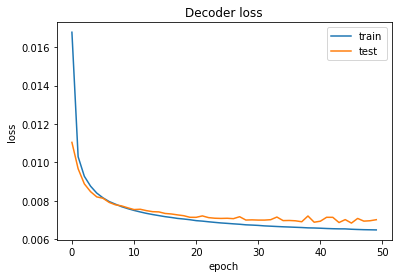

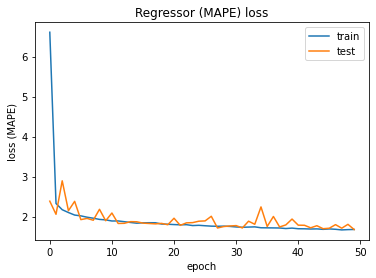

In [10]:
encoder = build_encoder(latent_dims)
decoder = build_decoder(latent_dims)
cae = keras.Sequential([encoder, decoder])
cae.compile(loss='mse', optimizer='adam')
history = cae.fit(X_train, X_train, 
                  validation_data=(X_test, X_test),
                  epochs=nepochs, batch_size=batch_size, verbose=0)
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Decoder loss')

for layer in encoder.layers:
    layer.trainable = False

regressor = build_regressor(latent_dims)
cae = keras.Sequential([encoder, regressor])
cae.compile(loss='mape', optimizer='adam')
history = cae.fit(X_train, Y_train, 
                  validation_data=(X_test, Y_test),
                  epochs=nepochs, batch_size=batch_size, verbose=0)
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss (MAPE)')
plt.xlabel('epoch')
plt.legend()
plt.title('Regressor (MAPE) loss')

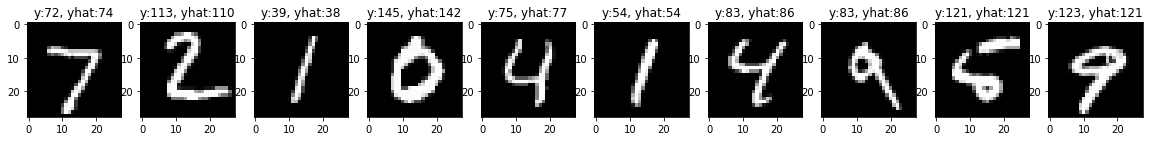

In [29]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(20,4))
for i in range(n):
    y_pred = cae.predict(tf.reshape(X_test[i], (1,28,28,1)))
    axs[i].imshow(tf.reshape(X_test[i], (28,28)))
    axs[i].set_title("y:{:.0f}, yhat:{:.0f}".format(Y_test[i], y_pred[0][0]))